In [17]:
import warnings

import geopandas as gpd
import pandas as pd
import math
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import shapely
from shapely.geometry import Polygon
from shapely import wkb
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import MultiPolygon

import contextily as cx
import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from rasterio import features
from rasterio.enums import Resampling
from affine import Affine

import stackstac
import pystac_client
import dask
from rasterstats import zonal_stats
import xarray as xr
import rioxarray
import geoarrow.pyarrow as ga
import pyarrow as pa
import pyarrow.parquet as pq
import requests
import yaml
from box import Box

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
from torchvision.transforms import v2
from einops import rearrange, reduce, repeat

import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"
warnings.filterwarnings("ignore")

### Get embeddings for a given region

In [ ]:
# Read in embeddings for a given region
embeddings = gpd.read_parquet('data/ga_256_2022-06-01_2022-08-31_tile_embeddings_final_1933.parquet')
aoi = embeddings.geometry.unary_union # Get AOI that embeddings cover

print(f'Number of embeddings: {len(embeddings)}')
print(embeddings.crs)

Number of embeddings: 1933
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degre

#### Label embeddings with presence or absence of pit lake

##### Get labeled pit lakes from Aquarry QA dataset


In [26]:
# Load Aquarry QA'ed data
psql_bboxes = gpd.read_file('data/aquarry_psql_layer.csv')
psql_bboxes = gpd.GeoDataFrame(psql_bboxes,geometry = psql_bboxes['field_8'].apply(wkb.loads),crs='epsg:4326') # Convert WKB geometry

psql_bboxes.columns = ['cc', 'objectid', 'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry','field_9', 'category', 'field_11', 'geometry']

# Get confirmed pit lakes in the given AOI
aoi_bboxes = psql_bboxes[psql_bboxes.geometry.intersects(aoi)]
print(f'Features confirmed as pit lakes or questionable during QA: {(aoi_bboxes['category'].isin(['a', 'q'])).sum()}')

# Ensure CRS alignment
crs = embeddings.crs 
aoi_bboxes = aoi_bboxes.to_crs(crs)

Features confirmed as pit lakes or questionable during QA: 279


##### Label embeddings

In [8]:
# Define function that marks each chip in intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings(embeddings, polygons):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    embeddings (GeoDataFrame): positive chip embeddings
    polygons (GeoDataFrame): pit lakes intersecting with the given AOI
    
    Returns:
    data_flat (GeoDataFrame): embedding chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    data = gpd.sjoin(embeddings, polygons, predicate='intersects',how = 'left',rsuffix="_1")
    data['pit_lake'] = 0 # Initialize column
    data.loc[~data['index__1'].isna(), 'pit_lake'] = 1 # Assign 1 if intersects with pit lakes

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.

    # Drop duplicates if you want to keep only one row per index
    data = data.drop_duplicates(subset=['geometry'])

    print(f'Number of positive samples: {(data['pit_lake'] == 1).sum()}') 

    # Flatten embedding to an array of length 1024
    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    return data_flat

In [9]:
# Label chips with pit lakes
data = LabelEmbeddings1_5(embeddings, aoi_bboxes)

Number of positive samples: 231


### Run MLP classifier model on embeddings

##### Create embedding dataset

In [15]:
# Define model dataset class
class MLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (torch.Tensor): Input embeddings with shape (num_samples, 1024).
            labels (torch.Tensor): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [ ]:
embeddings_array = data['embedding']
labels_array = data['pit_lake']

embs_dataset = MLPDataset(embeddings_array, labels_array)  
dataset_loader = DataLoader(embs_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

##### Run model

In [12]:
# Define model architecture
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        # Define the layers of the MLP
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Pass through the output layer and apply sigmoid for binary classification
        x = torch.sigmoid(self.output_layer(x))
        return x

In [14]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLPBinaryClassifier()
model.load_state_dict(torch.load("pit_lake_clf.pth"))
model.to(device)

MLPBinaryClassifier(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)

In [21]:
# Predict pit lakes from embeddings

model.eval()
criterion = nn.BCELoss(reduction='mean') 

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []
threshold = 0.5  # Adjust this threshold to toggle precision/recall

for inputs, labels in dataset_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > threshold).float() 
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

#### Evaluate results

Precision on test set: 0.6945
Recall on test set: 0.8268
Accuracy on test set: 0.9359
F1 score on test set: 0.7549
Total chips: 1933
True positives: 231.0
Predicted positives: 275.0


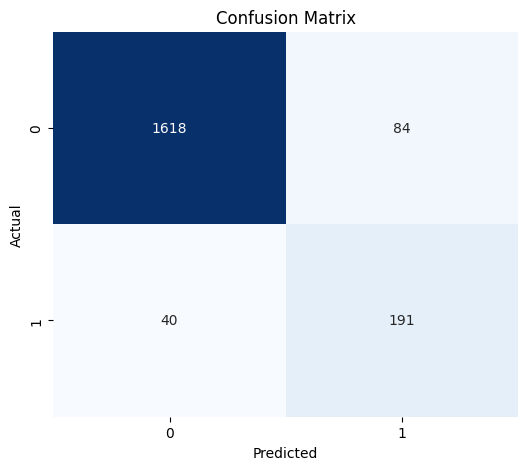

In [22]:
# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, all_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {all_predictions.sum()}')

# Confusion Matrix
cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


##### Visualize predicted results

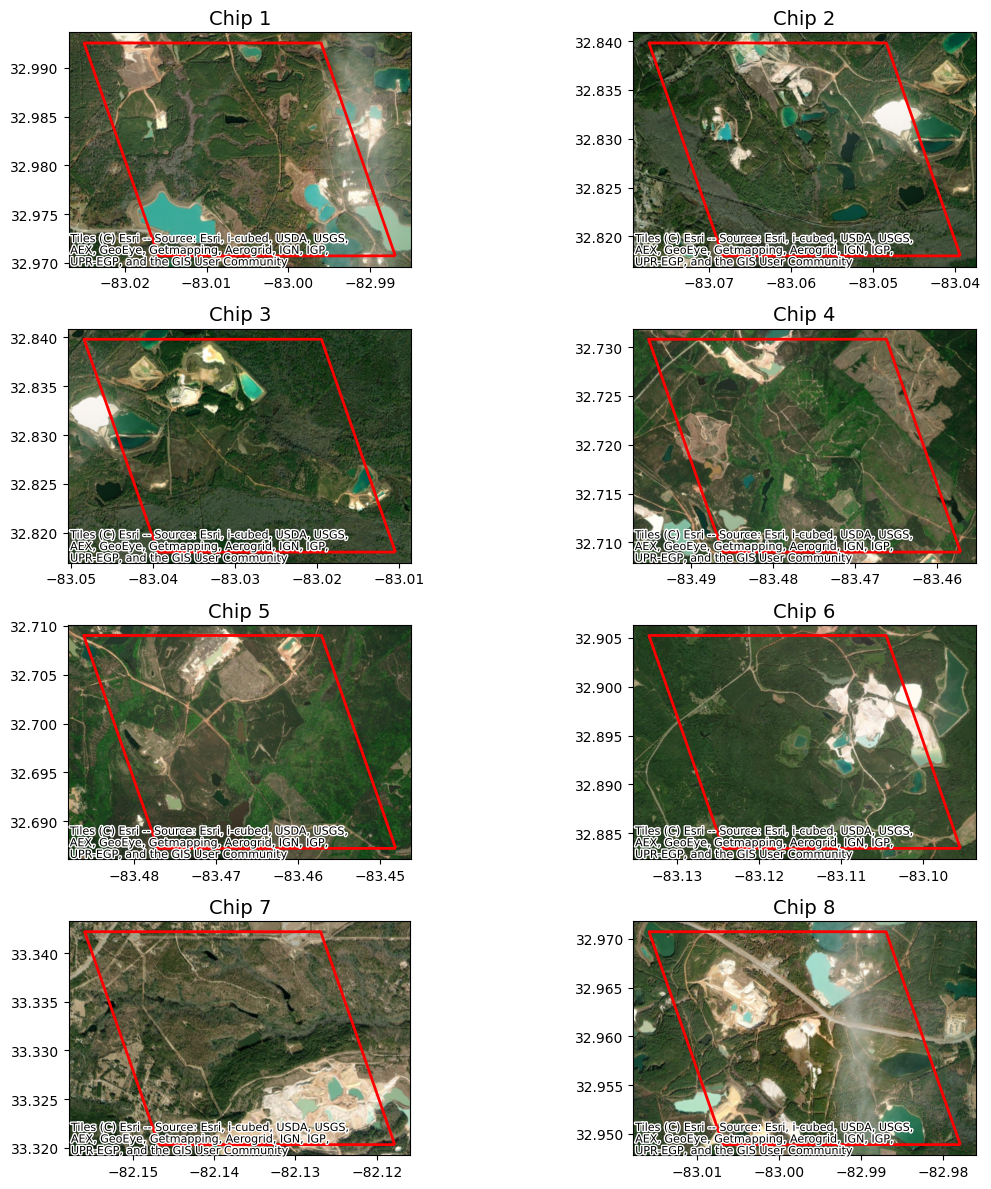

In [ ]:
# Get highest predicted probability chips
predictions_gdf = gpd.GeoDataFrame(all_predicted_outputs, geometry = data.geometry, columns = ['pit_lake_prob'], crs = data.crs)
predictions_gdf = predictions_gdf.sort_values(by = 'pit_lake_prob', ascending = False)
chips_to_viz = predictions_gdf.geometry.iloc[0:8] # Get top 8 chips

## Set up image plots
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()

# Get basemap provider
providers = cx.providers.flatten()
basemap_source = providers['Esri.WorldImagery']

# Plot each chip
for i, (chip, ax) in enumerate(zip(chips_to_viz, axes)):
    # Create a GeoDataFrame for just this chip
    chip_gdf = gpd.GeoDataFrame(geometry=[chip], crs=predictions_gdf.crs)
    
    # Plot chip outline
    chip_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

    # Add basemap
    cx.add_basemap(ax, crs=predictions_gdf.crs, source=basemap_source)

    # Set title and axis labels
    ax.set_title(f"Chip {i+1}", fontsize=14)
    #ax.set_xticks([])
    #ax.set_yticks([])

# Adjust layout
plt.tight_layout()
plt.show()

##### Save to files

In [27]:
# Define functions to create shapefile and CSV
def CreateShapefile(gdf, predictions, filename):
    predictions_gdf = gpd.GeoDataFrame(predictions, geometry = gdf.geometry, columns = ['pit_lake'], crs = '4326')
    file_name = f'file_path/{filename}.shp' # Adjust to correct file path
    predictions_gdf.to_file(file_name)

    return

def CreateCSV(gdf, predictions, filename):
    predictions_gdf = gpd.GeoDataFrame(predictions, geometry = gdf.geometry, columns = ['pit_lake'], crs = '4326')
    file_name = f'file_path/{filename}.csv' # Adjust to correct file path

    predictions_gdf["geometry_wkb"] = predictions_gdf.geometry.apply(lambda geom: geom.wkb)

    # Save to CSV (excluding original geometry column)
    predictions_gdf = predictions_gdf.drop(columns=["geometry"])
    predictions_gdf.to_csv(file_name, index=False) # Don't keep index in CSV
    
    return

In [ ]:
# Choose how to export and inspect chip classification results: export to shapefile or CSV

# Shapefile export
CreateShapefile(data, all_predictions, 'file_name') 

# CSV export
CreateCSV(data, all_predictions, 'file_name')

### Filter chips by NDWI to get likely pit lake polygons

#### Define functions to filter NDWI

In [ ]:
# Optimize GDAL settings for cloud optimized reading
def SearchSTAC(aoi, start, end):
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["AWS_REQUEST_PAYER"] = "requester"

    STAC_API = "https://earth-search.aws.element84.com/v1"
    COLLECTION = "sentinel-2-l2a"

    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start}/{end}",
        intersects=aoi,
        #max_items=,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    all_items = search.get_all_items()

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    print(f"Found {len(items)} items")

    return items, dates

# CHANGE TARGET PROJECTION AS NEEDED
# Retrieve the pixel values for the bounding box in the target projection.
def RetrievePixels(items,aoi_bounds):
    dask.config.set({"array.slicing.split_large_chunks": True})
    stack = None

    if len(items) != 0:
        #epsg = items[0].properties["proj:epsg"]
        gsd = 10
        valid_stacks = []
        bounds_gdf = gpd.GeoDataFrame(geometry=[aoi_bounds], crs='EPSG:8857') # Change projection based on CRS that chips were embedded in
        transformed_bbox = bounds_gdf.geometry[0].bounds

    if len(items) > 5:
        rand_idx = random.sample(range(0, len(items)), 5)
        items = [items[id] for id in rand_idx]
        print(f'Reduced items to {len(items)}')

    for item in items:
        try:
            # Attempt to create the stack for the current item
            stack = stackstac.stack(
                [item],  # Process one item at a time
                snap_bounds=True,
                epsg=8857,
                resolution=gsd,
                dtype="float32",
                rescale=False,
                fill_value=np.float32(0),
                assets=["green", "nir"],
                resampling=Resampling.nearest,
                chunksize=512,
                bounds=transformed_bbox
            )
            valid_stacks.append(stack)
        except RuntimeError as e:
            # Log and skip the problematic item
            print(f'Error creating stack for item {item.id}: {e}')
            continue

        if len(valid_stacks) != 0:
            combined_stack = dask.array.concatenate(valid_stacks, axis=0).compute()
            #stack = stack.compute()
        
    return stack

 # Calculate NDWI and create water mask 
def CalculateNDWI(image):
    ndwi = image
    green = image.sel(band="green")
    nir = image.sel(band="nir")

    ndwi = (green - nir) / (green + nir)
    return ndwi

def RasterstoPolygons(raster):
    raster_array = raster.values # convert to numpy array
    mask = raster_array.astype(bool)
    
    # Get affine transform correctly from rioxarray
    raster.rio.write_crs('epsg:8857', inplace=True)
    xmin, xmax = raster.x.min().item(), raster.x.max().item()
    ymin, ymax = raster.y.min().item(), raster.y.max().item()

    # Get resolution (assuming uniform spacing)
    xres = abs(raster.x[1] - raster.x[0]).item()
    yres = abs(raster.y[1] - raster.y[0]).item()

    transform = Affine(xres, 0, xmin, 0, -yres, ymax)  # Notice -yres because Y decreases

    if mask.any():
        shapes = features.shapes(raster_array, mask=mask, transform=transform)
        geometries = [shape(geom) for geom, _ in shapes]
    else:
        geometries = []

    return geometries    

In [ ]:
# Combine utility functions to produce filtered water multipolygons
def NDWIFilter(embs_with_polys):
    # Date range
    start = "2022-06-01"    
    end = "2022-08-31"
    filtered_polys = []

    # For each chip, get NDWI and filter raster
    for i in range(len(embs_with_polys)):
        try:
            #Get NDWI
            aoi_epsg4326 = embs_with_polys['geometry'].to_crs(epsg=4326).iloc[i]
            bounds = embs_with_polys['geometry'].iloc[i]   # Should be in epsg:8857

            ndwiimages, ndwidates = SearchSTAC(aoi_epsg4326, start, end) 

            #try: 
            ndwistack = RetrievePixels(ndwiimages, bounds)
            summer_composite = ndwistack.groupby('band').median(dim = 'time')
            ndwi_summer = CalculateNDWI(summer_composite)

                # Compute mask
            ndwi_threshold = 0.05
            water_mask = xr.where(ndwi_summer > ndwi_threshold, 1, 0)

            print(f'Water mask positive pixels: {water_mask.sum().values}')

            # Get polygons for the given raster, and store polygons
            filtered_polys.append(RasterstoPolygons(water_mask))
        except AttributeError:
            filtered_polys.append([])
            print(f'Something went wrong on {i}')

    # Combine chip polygons into multipolygons
    embs_with_polys['pit_lake_polygons'] = filtered_polys
    embs_with_polys["pit_lake_geoms"] = embs_with_polys["pit_lake_polygons"].apply(lambda x: MultiPolygon(x) if x else None)

    # Add buffer to chip polygons to merge nearby polygons, then merge polygons
    embs_with_polys["pit_lake_geoms"] = embs_with_polys["pit_lake_geoms"].apply(lambda x: unary_union([x.buffer(0.0005)]) if x else None)

    # Explode back into individual polygons to get separate pit lakes
    embs_with_polys["exploded"] = embs_with_polys['pit_lake_geoms'].apply(lambda x: x.geoms if type(x) == MultiPolygon else x)
    embs_with_polys = embs_with_polys.explode("exploded", ignore_index=False) 

    return embs_with_polys

#### Run NDWI filtering on positives from chip classification

In [ ]:
# Get positive prediction chips
data_predicted = gpd.GeoDataFrame({'mine_prob': all_predicted_outputs,'ground_truth': all_ground_truths}, 
                                    geometry = data.reset_index(drop=True).geometry, 
                                    crs = '4326').to_crs(epsg=8857) # Convert to same CRS as polygons to ensure same alignment after conversion
data_positives = data_predicted[data_predicted['mine_prob'] > 0.5]
print(f'Check if any geometries are NA: {data_positives.geometry.isna().sum()}')

# Get NDWI for chip and polygons
data_positives_polys = NDWIFilter(data_positives)

# Clean up dataframe and create updated prediction column
data_positives_polys['updated_preds'] = data_positives_polys['exploded'].apply(lambda x: 1 if x is not None else 0)
data_positives_polys = data_positives_polys.drop(columns = ['pit_lake_polygons', 'pit_lake_geoms'])

# CHANGE THIS TO GET MULTIPOLYGON
data_positives_polys_chips = data_positives_polys.drop_duplicates('geometry') # Getting rid of individual pit lake polygons

# Merge back into predictions dataframe
data_predicted_updated = data_predicted.merge(data_positives_polys_chips[['geometry','updated_preds']], on='geometry', how='left')
data_predicted_updated.loc[data_predicted_updated['updated_preds'].isna(), 'updated_preds'] = 0 

In [ ]:
# Evaluate pit lake water polygons at a chip level
updated_predictions = np.array(data_predicted_updated['updated_preds'])

precision = precision_score(all_ground_truths, updated_predictions, average='binary')
recall = recall_score(all_ground_truths, updated_predictions, average='binary')
f1 = f1_score(all_ground_truths, updated_predictions, average='binary')
accuracy = accuracy_score(all_ground_truths, updated_predictions)

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f'Accuracy on test set: {accuracy:.4f}')
print(f"F1 score on test set: {f1:.4f}")
print(f'Total chips: {len(all_ground_truths)}')
print(f'True positives: {all_ground_truths.sum()}')
print(f'Predicted positives: {updated_predictions.sum()}')

# Confusion Matrix
cm = sklearn.metrics.confusion_matrix(all_ground_truths, updated_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Visualize pit lake polygons

In [ ]:
# Get highest predicted probability chips
data_export = gpd.GeoDataFrame(data_positives_polys.drop(columns = 'geometry'), geometry = 'exploded')
data_export = data_export.sort_values(by = 'pit_lake_prob', ascending = False)
chips_to_viz = data_export.geometry.iloc[0:4] # Get top 4 chips

## Set up image plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Get basemap provider
providers = cx.providers.flatten()
basemap_source = providers['Esri.WorldImagery']

# Plot each chip
for i, (chip, ax) in enumerate(zip(chips_to_viz, axes)):
    # Create a GeoDataFrame for just this chip
    chip_gdf = gpd.GeoDataFrame(geometry=[chip], crs=predictions_gdf.crs)
    
    # Plot chip outline
    chip_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

    # Add basemap
    cx.add_basemap(ax, crs=predictions_gdf.crs, source=basemap_source)

    # Set title and axis labels
    ax.set_title(f"Chip {i+1}", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

##### Save pit lake polygons as shapefile, CSV

In [ ]:
def CreatePolysShapefile(gdf, filename):
    file_name = f'file_path/{filename}.shp' # Adjust to correct file path
    predictions_gdf.to_file(file_name)

    return

def CreatePolysCSV(gdf, filename):
    file_name = f'file_path/{filename}.csv' # Adjust to correct file path

    gdf["geometry_wkb"] = gdf.geometry.apply(lambda geom: geom.wkb)

    # Save to CSV (excluding original geometry column)
    gdf = gdf.drop(columns=["geometry"])
    gdf.to_csv(file_name, index=False) # Don't keep index in CSV

    return


In [ ]:
# Create shapefiles
filename = 'sample_polygons' # Change filename
data_positives_polys['preds'] = 0
data_positives_polys.loc[data_positives_polys['mine_prob'] > 0.5, 'preds'] = 1
data_export = gpd.GeoDataFrame(data_positives_polys.drop(columns = 'geometry'), geometry = 'exploded')

CreatePolysShapefile(data_export, f'{filename}')
CreatePolysCSV(data_export, f'{filename}') 